# 📘 EDA Open3D - Analyse de Nuage de Points 3D

**Objectif** : Comprendre la géométrie des données LiDAR et trouver les paramètres optimaux

## 0. Configuration et Imports

In [1]:
import open3d as o3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import os
import sys
sys.path.append('../src')

import lidar_utils as lu

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# === FIX PODMAN/DOCKER ===
#os.makedirs('/tmp/runtime-root', exist_ok=True)
#os.environ['XDG_RUNTIME_DIR'] = '/tmp/runtime-root'

# Créer les dossiers de sortie
Path("../outputs").mkdir(parents=True, exist_ok=True)
Path("../config").mkdir(parents=True, exist_ok=True)

print("✅ Configuration conteneur activée")

✅ Configuration conteneur activée


In [3]:
# === PARAMÈTRES UTILISATEUR ===
INTERACTIVE_MODE = True
SAVE_SCREENSHOTS = True

CLASS_NAMES = {
    -1: 'Background',
    0: 'Antenna',
    1: 'Cable',
    2: 'Pole',
    3: 'Turbine'
}

COLOR_MAP = {
    -1: [0.8, 0.8, 0.8],
    0:  [0.0, 0.0, 1.0],
    1:  [1.0, 0.5, 0.0],
    2:  [0.5, 0.0, 0.5],
    3:  [0.0, 1.0, 0.0]
}

print(f"Mode : {'Interactif' if INTERACTIVE_MODE else 'Automatique'}")

Mode : Interactif


## 1. Fonction de visualisation CORRIGÉE

**Fix** : On centre la vue sur les données avec `reset_view_point()`

In [4]:
def show_and_save(geometries, name, zoom=0.7):
    """
    Affiche un nuage de points ET sauvegarde un screenshot.
    
    FIX : Centre automatiquement la caméra sur les données !
    """
    if SAVE_SCREENSHOTS:
        path = f"../outputs/{name}.png"
        
        vis = o3d.visualization.Visualizer()
        vis.create_window(
            window_name=name,
            width=1600,
            height=900,
            visible = INTERACTIVE_MODE
        )
        
        for geom in geometries:
            vis.add_geometry(geom)
        
        # === FIX CRUCIAL : Centrer la vue sur les données ===
        vis.reset_view_point(True)  # Centre la caméra sur toutes les géométries
        
        # Ajuster le zoom après centrage
        ctr = vis.get_view_control()
        ctr.set_zoom(zoom)
        
        # Forcer le rendu
        vis.poll_events()
        vis.update_renderer()
        
        # Sauvegarder
        vis.capture_screen_image(path, do_render=True)
        
        if INTERACTIVE_MODE:
            print(f"   👁️  Fermez la fenêtre '{name}' pour continuer...")
            vis.run()
        else:
            import time
            time.sleep(2)
        
        vis.destroy_window()
        print(f"   📸 Screenshot sauvé : {path}")
    else:
        o3d.visualization.draw_geometries(geometries, window_name=name)


print("✅ Fonction show_and_save() définie (avec centrage automatique)")

✅ Fonction show_and_save() définie (avec centrage automatique)


## 2. Chargement des données

In [5]:
file_path = "../datasets/raw/scene_1.h5"
df = lu.load_h5_data(file_path)

print("=" * 60)
print("📂 CHARGEMENT DONNÉES")
print("=" * 60)
print(f"✅ Fichier : {file_path}")
print(f"   Points  : {len(df):,}")
print(f"   Colonnes: {df.columns.tolist()}")

📂 CHARGEMENT DONNÉES
✅ Fichier : ../datasets/raw/scene_1.h5
   Points  : 57,500,000
   Colonnes: ['distance_cm', 'azimuth_raw', 'elevation_raw', 'reflectivity', 'r', 'g', 'b', 'ego_x', 'ego_y', 'ego_z', 'ego_yaw']


In [6]:
class_df = pd.DataFrame({
    "r": [38, 177, 129, 66],
    "g": [23, 132, 81, 132],
    "b": [180, 47, 97, 9],
    "class_id": [0, 1, 2, 3]
})

df = df.merge(class_df, on = ["r", "g", "b"], how = "left")
df["class_id"] = df["class_id"].fillna(-1)

In [8]:
# Distribution des classes
print("\n📊 Distribution des classes :")
for cid in sorted(df['class_id'].unique()):
    count = (df['class_id'] == cid).sum()
    pct = count / len(df) * 100
    print(f"   {CLASS_NAMES.get(cid, '?'):12s} : {count:6,d} ({pct:5.2f}%)")


📊 Distribution des classes :
   Background   : 56,499,492 (98.26%)
   Antenna      : 211,892 ( 0.37%)
   Cable        : 52,165 ( 0.09%)
   Pole         : 50,812 ( 0.09%)
   Turbine      : 685,639 ( 1.19%)


## 3. Diagnostic des coordonnées (SANS switch automatique)

On affiche les deux systèmes mais on **ne change rien automatiquement**.
Vous décidez manuellement si vous voulez utiliser ego_* ou pas.

In [9]:
df[['x', 'y', 'z']] = lu.spherical_to_local_cartesian(df)

In [10]:
print("=" * 60)
print("🔍 DIAGNOSTIC DES COORDONNÉES")
print("=" * 60)

# Référentiel MONDE
print("\n📍 Système MONDE (x, y, z) :")
print(f"   X: [{df['x'].min():8.1f}, {df['x'].max():8.1f}]  span={df['x'].max()-df['x'].min():.1f}m")
print(f"   Y: [{df['y'].min():8.1f}, {df['y'].max():8.1f}]  span={df['y'].max()-df['y'].min():.1f}m")
print(f"   Z: [{df['z'].min():8.1f}, {df['z'].max():8.1f}]  span={df['z'].max()-df['z'].min():.1f}m")

objects_monde = df[df['class_id'] != -1]
if len(objects_monde) > 0:
    print(f"   Z moyen objets : {objects_monde['z'].mean():.1f}m")

🔍 DIAGNOSTIC DES COORDONNÉES

📍 Système MONDE (x, y, z) :
   X: [  -295.5,    299.9]  span=595.4m
   Y: [  -294.9,    296.5]  span=591.4m
   Z: [   -98.4,     97.1]  span=195.5m
   Z moyen objets : 4.7m


In [11]:
# Référentiel EGO
print("\n📍 Système EGO (ego_x, ego_y, ego_z) :")
print(f"   X: [{df['ego_x'].min():8.1f}, {df['ego_x'].max():8.1f}]  span={df['ego_x'].max()-df['ego_x'].min():.1f}m")
print(f"   Y: [{df['ego_y'].min():8.1f}, {df['ego_y'].max():8.1f}]  span={df['ego_y'].max()-df['ego_y'].min():.1f}m")
print(f"   Z: [{df['ego_z'].min():8.1f}, {df['ego_z'].max():8.1f}]  span={df['ego_z'].max()-df['ego_z'].min():.1f}m")

if len(objects_monde) > 0:
    print(f"   Z moyen objets : {objects_monde['ego_z'].mean():.1f}m")


📍 Système EGO (ego_x, ego_y, ego_z) :
   X: [-168445.1,  71417.3]  span=239862.5m
   Y: [-164425.8,  66770.9]  span=231196.7m
   Z: [ 10000.0,  15590.0]  span=5590.0m
   Z moyen objets : 10510.2m


In [12]:
# === CHOIX MANUEL ===
# NOTE : Si Z négatifs = Normal pour drone/hélicoptère (sol sous le capteur)
# Mettez True pour utiliser les coordonnées EGO, False pour MONDE
USE_EGO_COORDS = False  # ← MODIFIEZ ICI SI BESOIN

if USE_EGO_COORDS:
    print("\n⚙️  CHOIX : Utilisation des coordonnées EGO")
    df['x_original'], df['y_original'], df['z_original'] = df['x'], df['y'], df['z']
    df['x'], df['y'], df['z'] = df['ego_x'], df['ego_y'], df['ego_z']
else:
    print("\n⚙️  CHOIX : Utilisation des coordonnées MONDE (par défaut)")


⚙️  CHOIX : Utilisation des coordonnées MONDE (par défaut)


## 4. Création du Point Cloud Open3D

In [13]:
# Runtime ~30sec
print("=" * 60)
print("🌐 CRÉATION POINT CLOUD")
print("=" * 60)

xyz = df[['x', 'y', 'z']].values

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)

colors = np.array([COLOR_MAP[cid] for cid in df['class_id'].values])
pcd.colors = o3d.utility.Vector3dVector(colors)

print(f"\n✅ Point cloud : {len(pcd.points):,} points")
print(f"   X: [{xyz[:,0].min():8.1f}, {xyz[:,0].max():8.1f}]")
print(f"   Y: [{xyz[:,1].min():8.1f}, {xyz[:,1].max():8.1f}]")
print(f"   Z: [{xyz[:,2].min():8.1f}, {xyz[:,2].max():8.1f}]")

🌐 CRÉATION POINT CLOUD

✅ Point cloud : 57,500,000 points
   X: [  -295.5,    299.9]
   Y: [  -294.9,    296.5]
   Z: [   -98.4,     97.1]


In [14]:
# VISUALISATION 1 : Données brutes
show_and_save([pcd], "1_donnees_brutes", zoom=0.7)

   👁️  Fermez la fenêtre '1_donnees_brutes' pour continuer...
   📸 Screenshot sauvé : ../outputs/1_donnees_brutes.png


## 5. Statistiques géométriques par classe

In [15]:
print("=" * 60)
print("📐 ANALYSE GÉOMÉTRIQUE PAR CLASSE")
print("=" * 60)

for cid in [0, 1, 2, 3]:
    subset = df[df['class_id'] == cid]
    
    if len(subset) == 0:
        print(f"\n⚠️  {CLASS_NAMES[cid]} : 0 points")
        continue
    
    xyz_sub = subset[['x', 'y', 'z']].values
    x_span = xyz_sub[:,0].max() - xyz_sub[:,0].min()
    y_span = xyz_sub[:,1].max() - xyz_sub[:,1].min()
    z_span = xyz_sub[:,2].max() - xyz_sub[:,2].min()
    
    spans = [x_span, y_span, z_span]
    max_span = max(spans)
    min_span = min([s for s in spans if s > 0.1])
    elongation = max_span / min_span if min_span > 0 else 0
    
    print(f"\n📦 {CLASS_NAMES[cid]} ({len(subset):,} pts) :")
    print(f"   Dimensions : X={x_span:.1f}m  Y={y_span:.1f}m  Z={z_span:.1f}m")
    print(f"   Elongation : {elongation:.2f}")
    print(f"   Z moyen    : {xyz_sub[:,2].mean():.1f}m")

📐 ANALYSE GÉOMÉTRIQUE PAR CLASSE

📦 Antenna (211,892 pts) :
   Dimensions : X=407.6m  Y=356.1m  Z=122.5m
   Elongation : 3.33
   Z moyen    : -3.7m

📦 Cable (52,165 pts) :
   Dimensions : X=462.5m  Y=529.4m  Z=124.4m
   Elongation : 4.26
   Z moyen    : -5.5m

📦 Pole (50,812 pts) :
   Dimensions : X=390.7m  Y=421.9m  Z=113.3m
   Elongation : 3.72
   Z moyen    : 5.8m

📦 Turbine (685,639 pts) :
   Dimensions : X=299.7m  Y=416.1m  Z=174.3m
   Elongation : 2.39
   Z moyen    : 8.0m


## 6. RANSAC - Suppression du sol

In [16]:
print("=" * 60)
print("🧹 RANSAC - SUPPRESSION DU SOL")
print("=" * 60)

print("\n🔬 Test seuils :")
for threshold in [0.1, 0.2, 0.3, 0.5]:
    _, inliers = pcd.segment_plane(
        distance_threshold=threshold,
        ransac_n=3,
        num_iterations=1000
    )
    pct = len(inliers) / len(pcd.points) * 100
    print(f"   {threshold:.1f}m → {len(inliers):,} pts sol ({pct:.1f}%)")

🧹 RANSAC - SUPPRESSION DU SOL

🔬 Test seuils :
   0.1m → 33,463,042 pts sol (58.2%)
   0.2m → 33,943,010 pts sol (59.0%)
   0.3m → 35,313,947 pts sol (61.4%)
   0.5m → 34,726,472 pts sol (60.4%)


In [17]:
RANSAC_THRESHOLD = 0.2  # ← MODIFIEZ SI BESOIN

plane_model, inliers = pcd.segment_plane(
    distance_threshold=RANSAC_THRESHOLD,
    ransac_n=3,
    num_iterations=1000
)

ground_cloud = pcd.select_by_index(inliers)
obstacle_cloud = pcd.select_by_index(inliers, invert=True)

pct_ground = len(inliers) / len(pcd.points) * 100

print(f"\n✅ Retenu : threshold={RANSAC_THRESHOLD}m")
print(f"   Sol       : {len(ground_cloud.points):,} pts ({pct_ground:.1f}%)")
print(f"   Obstacles : {len(obstacle_cloud.points):,} pts")


✅ Retenu : threshold=0.2m
   Sol       : 34,299,419 pts (59.7%)
   Obstacles : 23,200,581 pts


In [18]:
show_and_save([obstacle_cloud], "2_sans_sol", zoom=0.7)

   👁️  Fermez la fenêtre '2_sans_sol' pour continuer...
   📸 Screenshot sauvé : ../outputs/2_sans_sol.png


## 7. DBSCAN - Clustering

In [ ]:
# Runtime : ~
print("=" * 60)
print("🔗 DBSCAN - CLUSTERING")
print("=" * 60)

print("\n🔬 Test eps :")
for eps in [0.5, 1.0, 1.5, 2.0]:
    labels_test = np.array(obstacle_cloud.cluster_dbscan(
        eps=eps, min_points=10, print_progress=False
    ))
    n = labels_test.max() + 1
    noise = (labels_test == -1).sum()
    print(f"   eps={eps:.1f}m → {n:3d} clusters, {noise:,} bruit ({noise/len(labels_test)*100:.1f}%)")

🔗 DBSCAN - CLUSTERING

🔬 Test eps :


In [ ]:
DBSCAN_EPS = 1.5
DBSCAN_MIN_POINTS = 10

labels = np.array(obstacle_cloud.cluster_dbscan(
    eps=DBSCAN_EPS,
    min_points=DBSCAN_MIN_POINTS,
    print_progress=True
))

n_clusters = labels.max() + 1
n_noise = (labels == -1).sum()
pct_noise = n_noise / len(labels) * 100

print(f"\n✅ Retenu : eps={DBSCAN_EPS}m, min_points={DBSCAN_MIN_POINTS}")
print(f"   Clusters : {n_clusters}")
print(f"   Bruit    : {n_noise:,} ({pct_noise:.1f}%)")


✅ Retenu : eps=1.5m, min_points=10
   Clusters : 116
   Bruit    : 3,255 (16.1%)
Precompute neighbors.[========================================] 100%


In [235]:
# Colorier par cluster
max_label = labels.max()
cmap = plt.get_cmap("tab20")
cluster_colors = cmap(labels / (max_label if max_label > 0 else 1))
cluster_colors[labels < 0] = [0.5, 0.5, 0.5, 1]
obstacle_cloud.colors = o3d.utility.Vector3dVector(cluster_colors[:, :3])

show_and_save([obstacle_cloud], "3_clustering", zoom=0.7)

   👁️  Fermez la fenêtre '3_clustering' pour continuer...
   📸 Screenshot sauvé : ../outputs/3_clustering.png


## 8. Bounding Boxes

In [236]:
print("=" * 60)
print("📦 BOUNDING BOXES")
print("=" * 60)

geometries = [obstacle_cloud]
bboxes_stats = []

for i in range(n_clusters):
    indices = np.where(labels == i)[0]
    if len(indices) < 10:
        continue
    
    cluster_pcd = obstacle_cloud.select_by_index(indices)
    obb = cluster_pcd.get_oriented_bounding_box()
    obb.color = (1, 0, 0)
    geometries.append(obb)
    
    bboxes_stats.append({
        'cluster_id': i,
        'n_points': len(indices),
        'center_z': obb.center[2],
        'height': obb.extent[2],
        'volume': obb.extent[0] * obb.extent[1] * obb.extent[2]
    })

bboxes_df = pd.DataFrame(bboxes_stats)

print(f"\n✅ {len(bboxes_stats)} bboxes générées")
print("\n📊 Top 5 (volume) :")
print(bboxes_df.nlargest(5, 'volume')[['cluster_id', 'n_points', 'height', 'volume']].to_string(index=False))

📦 BOUNDING BOXES

✅ 115 bboxes générées

📊 Top 5 (volume) :
 cluster_id  n_points    height      volume
         51      1181 10.210437 3864.583519
         55      2258  5.249796 3744.259434
         32       386  3.738567  581.481672
         54      1324  4.736612  549.921663
         66       277  4.333672  501.866512


In [237]:
show_and_save(geometries, "4_bboxes", zoom=0.5)

   👁️  Fermez la fenêtre '4_bboxes' pour continuer...
   📸 Screenshot sauvé : ../outputs/4_bboxes.png


## 9. Export config

In [238]:
optimal_params = {
    'preprocessing': {
        'ransac': {'distance_threshold': float(RANSAC_THRESHOLD)}
    },
    'clustering': {
        'dbscan': {'eps': float(DBSCAN_EPS), 'min_points': int(DBSCAN_MIN_POINTS)}
    },
    'metadata': {
        'coords': 'ego' if USE_EGO_COORDS else 'world',
        'clusters': int(n_clusters)
    }
}

config_path = Path("../config/optimal_params.yaml")
with open(config_path, 'w') as f:
    yaml.dump(optimal_params, f, sort_keys=False)

print(f"✅ Config sauvée : {config_path}")
print(f"\n🎯 RÉSUMÉ :")
print(f"   RANSAC : {RANSAC_THRESHOLD}m ({pct_ground:.0f}% sol)")
print(f"   DBSCAN : eps={DBSCAN_EPS}m → {n_clusters} clusters")
print(f"   Coords : {'EGO' if USE_EGO_COORDS else 'MONDE'}")

✅ Config sauvée : ../config/optimal_params.yaml

🎯 RÉSUMÉ :
   RANSAC : 0.2m (65% sol)
   DBSCAN : eps=1.5m → 116 clusters
   Coords : MONDE


## 10. Graphiques

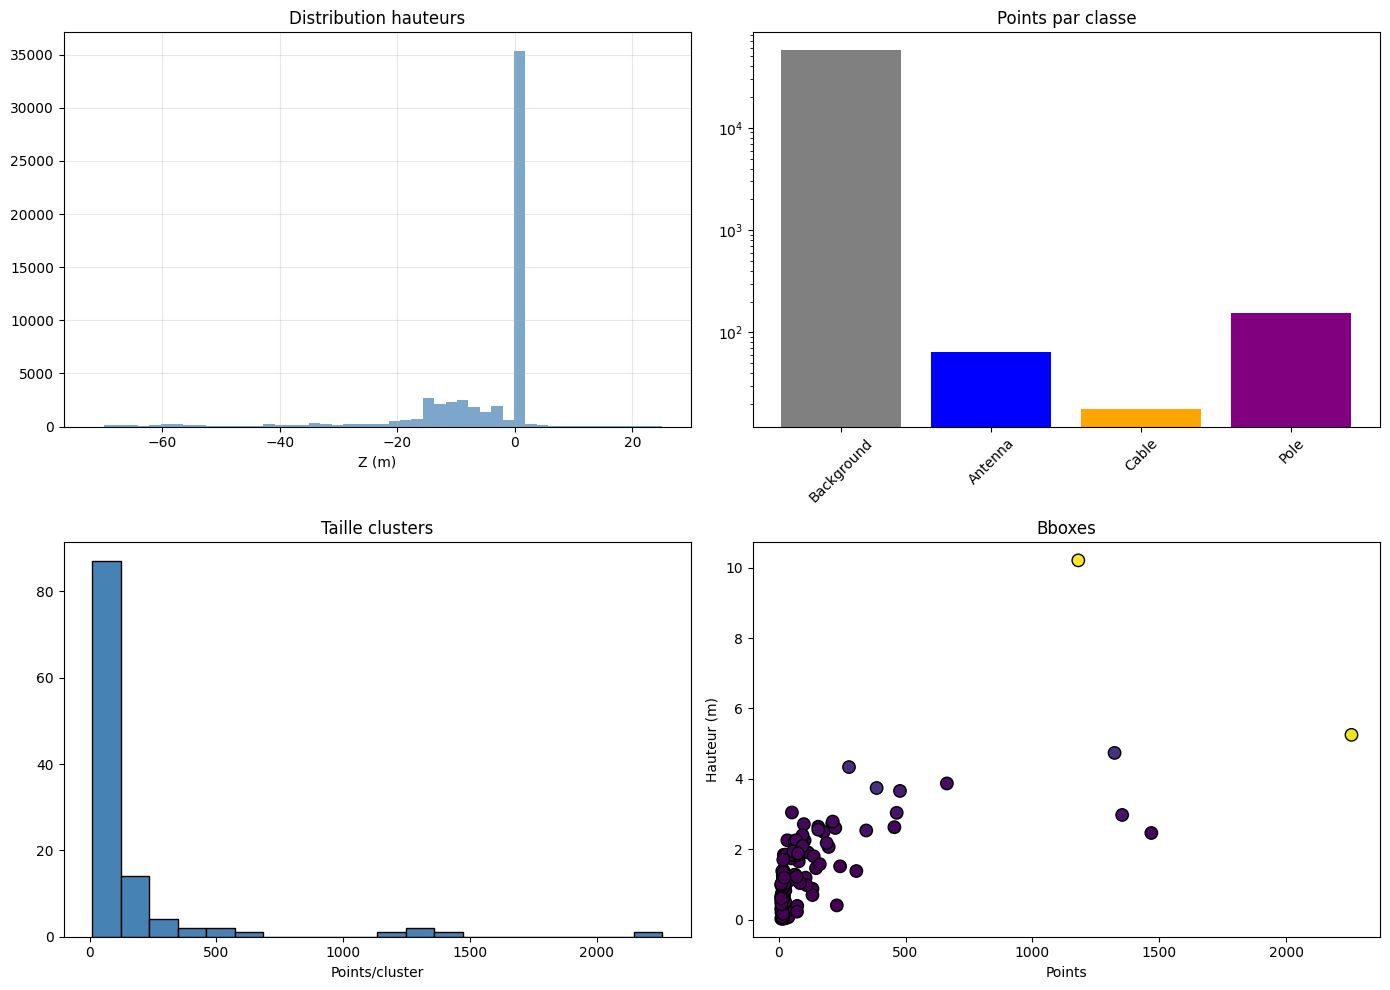

📊 Sauvé : outputs/0_synthese.png


In [239]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution Z
ax = axes[0, 0]
ax.hist(df['z'], bins=50, alpha=0.7, color='steelblue')
ax.set_xlabel('Z (m)')
ax.set_title('Distribution hauteurs')
ax.grid(True, alpha=0.3)

# Classes
ax = axes[0, 1]
counts = df['class_id'].value_counts().sort_index()
ax.bar(range(len(counts)), counts.values, color=['gray','blue','orange','purple','green'])
ax.set_xticks(range(len(counts)))
ax.set_xticklabels([CLASS_NAMES.get(i,'?') for i in counts.index], rotation=45)
ax.set_yscale('log')
ax.set_title('Points par classe')

# Clusters
ax = axes[1, 0]
if len(bboxes_df) > 0:
    ax.hist(bboxes_df['n_points'], bins=20, color='steelblue', edgecolor='black')
    ax.set_xlabel('Points/cluster')
    ax.set_title('Taille clusters')

# Bboxes
ax = axes[1, 1]
if len(bboxes_df) > 0:
    ax.scatter(bboxes_df['n_points'], bboxes_df['height'], 
               c=bboxes_df['volume'], cmap='viridis', s=80, edgecolors='black')
    ax.set_xlabel('Points')
    ax.set_ylabel('Hauteur (m)')
    ax.set_title('Bboxes')

plt.tight_layout()
plt.savefig('../outputs/0_synthese.png', dpi=150)
plt.show()
print("📊 Sauvé : outputs/0_synthese.png")

In [240]:
print("\n✅ EDA TERMINÉE !")


✅ EDA TERMINÉE !
